This example builds HMM and MSMs on the alanine_dipeptide dataset using varing lag times
and numbers of states, and compares the relaxation timescales


In [1]:
from __future__ import print_function
import os
%matplotlib inline
from matplotlib.pyplot import *
from msmbuilder.featurizer import SuperposeFeaturizer
from msmbuilder.example_datasets import AlanineDipeptide
from msmbuilder.hmm import GaussianHMM
from msmbuilder.cluster import KCenters
from msmbuilder.msm import MarkovStateModel

## First: load and "featurize"

Featurization refers to the process of converting the conformational
snapshots from your MD trajectories into vectors in some space $\mathbb{R}^N$ that can be manipulated and modeled by subsequent analyses. The Gaussian HMM, for instance, uses Gaussian emission distributions, so it models the trajectory as a time-dependent
mixture of multivariate Gaussians.

In general, the featurization is somewhat of an art. For this example, we're using Mixtape's `SuperposeFeaturizer`, which superposes each snapshot onto a reference frame (`trajectories[0][0]` in this example), and then measure the distance from each
atom to its position in the reference conformation as the 'feature'

In [2]:
print(AlanineDipeptide.description())

dataset = AlanineDipeptide().get()
trajectories = dataset.trajectories
topology = trajectories[0].topology

indices = [atom.index for atom in topology.atoms if atom.element.symbol in ['C', 'O', 'N']]
featurizer = SuperposeFeaturizer(indices, trajectories[0][0])
sequences = featurizer.transform(trajectories)

The dataset consists of ten 10ns trajectories of of alanine dipeptide,
simulated using OpenMM 6.0.1 (CUDA platform, NVIDIA GTX660) with the
AMBER99SB-ILDN force field at 300K (langevin dynamics, friction coefficient
of 91/ps, timestep of 2fs) with GBSA implicit solvent. The coordinates are
saved every 1ps. Each trajectory contains 9,999 snapshots.

The dataset, including the script used to generate the dataset
is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1026131



### Now `sequences` is our featurized data.

In [3]:
lag_times = [1, 10, 20, 30, 40]
hmm_ts0 = {}
hmm_ts1 = {}
n_states = [3, 5]

for n in n_states:
    hmm_ts0[n] = []
    hmm_ts1[n] = []
    for lag_time in lag_times:
        strided_data = [s[i::lag_time] for s in sequences for i in range(lag_time)]
        hmm = GaussianHMM(n_states=n, n_init=1).fit(strided_data)
        timescales = hmm.timescales_ * lag_time
        hmm_ts0[n].append(timescales[0])
        hmm_ts1[n].append(timescales[1])
        print('n_states=%d\tlag_time=%d\ttimescales=%s' % (n, lag_time, timescales))
    print()

n_states=3	lag_time=1	timescales=[ 135.11400429    1.660205  ]
n_states=3	lag_time=10	timescales=[ 209.43678994    6.07974438]
n_states=3	lag_time=20	timescales=[ 222.936281      6.22883389]
n_states=3	lag_time=30	timescales=[ 227.81527385    7.55691363]
n_states=3	lag_time=40	timescales=[ 231.2537131     8.81003209]

n_states=5	lag_time=1	timescales=[ 139.42203669    4.4603255     1.66401839    0.93722284]
n_states=5	lag_time=10	timescales=[ 211.17955801    6.08706038    3.27684305    2.49249265]
n_states=5	lag_time=20	timescales=[ 224.89090373    6.37971282    3.94086206    3.6774155 ]
n_states=5	lag_time=30	timescales=[ 228.62903203    7.66178536    6.56593671    5.49712998]
n_states=5	lag_time=40	timescales=[ 229.72004787    8.97053548    8.73164719]



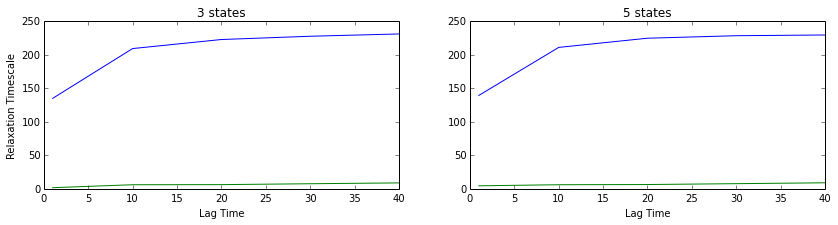

In [4]:
figure(figsize=(14,3))

for i, n in enumerate(n_states):
    subplot(1,len(n_states),1+i)
    plot(lag_times, hmm_ts0[n])
    plot(lag_times, hmm_ts1[n])
    if i == 0:
        ylabel('Relaxation Timescale')
    xlabel('Lag Time')
    title('%d states' % n)

show()

In [5]:
msmts0, msmts1 = {}, {}
lag_times = [1, 10, 20, 30, 40]
n_states = [4, 8, 16, 32, 64]

for n in n_states:
    msmts0[n] = []
    msmts1[n] = []
    for lag_time in lag_times:
        assignments = KCenters(n_clusters=n).fit_predict(sequences)
        msm = MarkovStateModel(lag_time=lag_time, verbose=False).fit(assignments)
        timescales = msm.timescales_
        msmts0[n].append(timescales[0])
        msmts1[n].append(timescales[1])
        print('n_states=%d\tlag_time=%d\ttimescales=%s' % (n, lag_time, timescales[0:2]))
    print()

n_states=4	lag_time=1	timescales=[ 75.02996861   3.10191644]
n_states=4	lag_time=10	timescales=[ 191.88390011    5.78963831]
n_states=4	lag_time=20	timescales=[ 161.88152892    5.53872999]
n_states=4	lag_time=30	timescales=[ 185.39764113    7.11876713]
n_states=4	lag_time=40	timescales=[ 226.61615873    7.22322264]

n_states=8	lag_time=1	timescales=[ 83.38962275   2.45300736]
n_states=8	lag_time=10	timescales=[ 187.33905866    4.00629989]
n_states=8	lag_time=20	timescales=[ 219.43478778    5.44867013]
n_states=8	lag_time=30	timescales=[ 221.11064061    7.0820978 ]
n_states=8	lag_time=40	timescales=[ 215.36152251    8.64368949]

n_states=16	lag_time=1	timescales=[ 104.52931606    3.33999948]
n_states=16	lag_time=10	timescales=[ 211.23290662    6.3406698 ]
n_states=16	lag_time=20	timescales=[ 224.12545993    6.16575075]
n_states=16	lag_time=30	timescales=[ 227.1522646     8.13724895]
n_states=16	lag_time=40	timescales=[ 232.37031245   10.44928358]

n_states=32	lag_time=1	timescales=[ 132

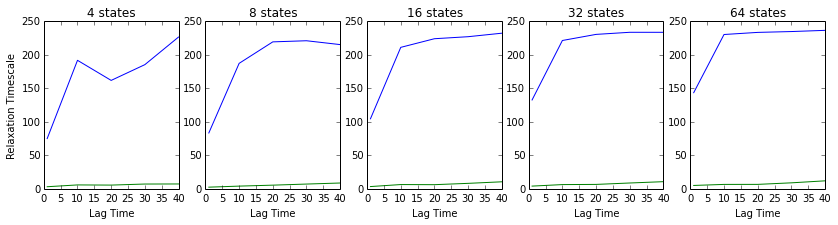

In [6]:
figure(figsize=(14,3))

for i, n in enumerate(n_states):
    subplot(1,len(n_states),1+i)
    plot(lag_times, msmts0[n])
    plot(lag_times, msmts1[n])
    if i == 0:
        ylabel('Relaxation Timescale')
    xlabel('Lag Time')
    title('%d states' % n)

show()